<a href="https://colab.research.google.com/github/wandb/awesome-dl-projects/blob/master/ml-tutorial/Investigating_EMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and Setups

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
import tensorflow_datasets as tfds

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%%capture
!pip install wandb

In [4]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
wandb.init(entity='wandb', project='emnist')

W&B Run: https://app.wandb.ai/wandb/emnist/runs/1833h9za

## Download EMNIST and Minor Investigation

In [6]:
# Gather Flowers dataset
(train_ds, validation_ds) = tfds.load(
    "emnist/bymerge",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True
)

builder = tfds.builder('emnist/bymerge')
builder.info

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/emnist/bymerge/3.0.0.incomplete3W7DFS/emnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/emnist/bymerge/3.0.0.incomplete3W7DFS/emnist-test.tfrecord


Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/bymerge/3.0.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='emnist',
    version=3.0.0,
    description='The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.

Note: Like the original EMNIST data, images provided here are inverted horizontally and rotated 90 anti-clockwise. You can use `tf.transpose` within `ds.map` to convert the images to a human-friendlier format.',
    homepage='https://www.nist.gov/itl/products-and-services/emnist-dataset',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=47),
    }),
    total_num_examples=814255,
    splits={
        'test': 116323,
        'train': 697932,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{cohen_afshar_tapson_schaik_2017,
        title={EMNIST: Extending MNIST to handwritten lett

### Points to note:

* We are using `bymerge` dataset of EMNIST. Here labels like `j`, `o`, `i` etc which look alike `J`, `O`, `I` are merged. 

* The EMNIST images provided here are inverted horizontally and rotated 90 anti-clockwise. We don't want to use it in this configuration. Thus we will rotate back the image by 90 deg clockwise. 

* We have total of 814255 images. They are 28x28 pixels in resolution with only one channel.

* We have 697932 images as training data.

* We have 116323 images as testing data.

* We have 47 classes. 


In [7]:
LABELS = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
          'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
          'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']
len(LABELS)

47

## Raw Visualization

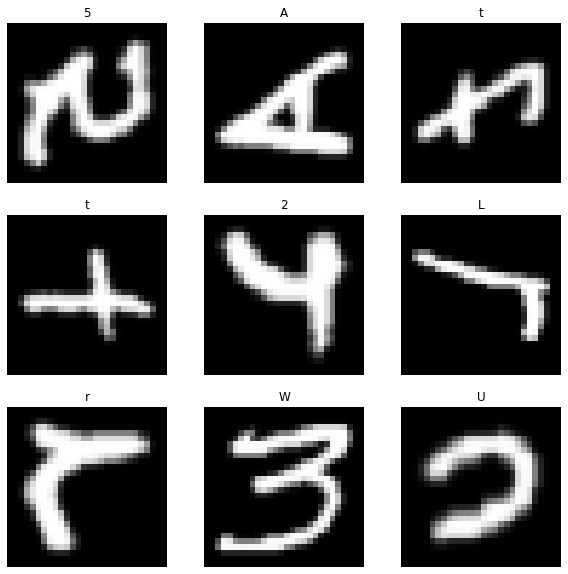

In [8]:
# Visualization
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(tf.squeeze(image, axis=2), cmap='gray')
  plt.title(LABELS[int(label)])
  plt.axis("off")

wandb.log({'emnist-raw': plt})

## Simple `tf.data` dataloader

(Used for human friendly visualization)

In [9]:
## We are transposing to rotate the image by 90 deg clockwise making the images friendly to visualize.
def transpose(image, label):
  image = tf.transpose(image, [1,0,2])
  return image, label

trainloader = (
    train_ds
    .shuffle(1024)
    .map(transpose, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

#### Quick Visualization
(Run the cell below multiple times to visualize different images.)

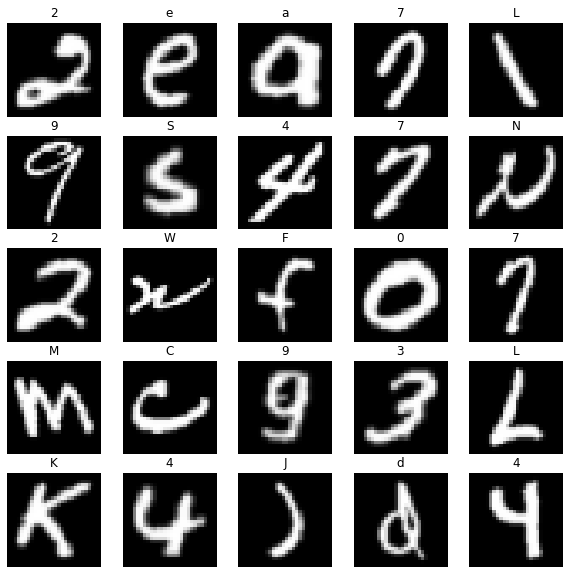

In [10]:
imgs, labels = next(iter(trainloader))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(tf.squeeze(imgs[n], axis=2), cmap='gray')
    plt.title(LABELS[int(labels[n])])
    plt.axis('off')

wandb.log({'emnist-transposed': plt})

## Class Distribution

In [11]:
def get_label(image, label):
  return label

trainloader = (
    train_ds
    .map(get_label, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # .batch(32)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [12]:
distribution_counter = np.zeros(len(LABELS))

In [13]:
for label in tqdm(trainloader):
  label = label.numpy()
  distribution_counter[label] = distribution_counter[label]+1

593242it [02:31, 3908.78it/s]


In [14]:
distribution_counter

array([29440., 32523., 29196., 29914., 28542., 26591., 29055., 30652.,
       28808., 28813.,  5469.,  3291., 11033.,  3949.,  4197.,  7718.,
        2144.,  2632., 12500.,  4871.,  4277., 17329.,  9882.,  6983.,
       23462.,  9103.,  2219.,  4302., 20083.,  8283., 13049.,  6457.,
        6238.,  4759.,  6083.,  4618.,  8510.,  4321.,  8640., 20915.,
        2158.,  3135.,  7391.,  9702.,  2521., 11970., 15514.])

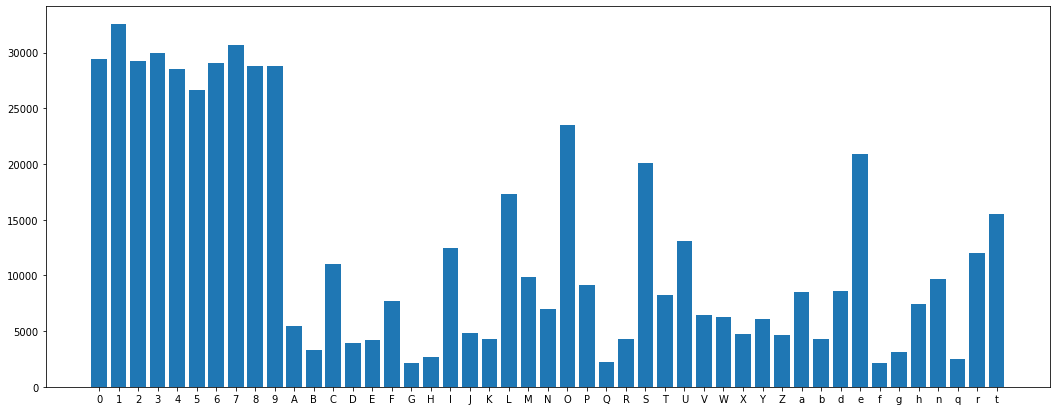

In [18]:
plt.figure(figsize=(18, 7))
plt.bar(LABELS, distribution_counter)

plt.savefig('class_distribution.png')

In [19]:
wandb.log({'class-distribution-image': [wandb.Image('class_distribution.png')]})

> Note: Click on the Run Page link generated after running `wandb.init()`. 